# About this notebook  

TBD...

# Data Loading

In [1]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
os.listdir("../input/cassava-leaf-disease-classification")

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'train_tfrecords',
 'test_tfrecords',
 'test_images',
 'train_images',
 'train.csv']

In [3]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")
# train = pd.read_csv("../input/cassava-leaf-disease-merged/oversample-0124.csv")  # label 0124 x3
test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")
display(train.head())
display(test.head())
display(label_map)

,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,1,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/home/ubuntu/work/pytorch/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

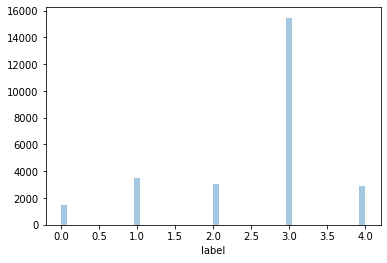

In [4]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = False
    print_freq = 100
    num_workers = 4
    model_name = "vit_base_patch16_384"  # resnext50_32x4d, seresnext50_32x4d, tf_efficientnet_b3_ns, vit_base_patch16_384, deit_base_patch16_384
    batch_size = 8
    gradient_accumulation_steps = 4
    size = 384 if "it_base_" in model_name else 512
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.2
    scheduler = "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    scheduler_batch_update = True
    epochs = 10
    # factor = 0.2  # ReduceLROnPlateau
    # patience = 4  # ReduceLROnPlateau
    # eps = 1e-6  # ReduceLROnPlateau
    # T_max = 10  # CosineAnnealingLR
    T_0 = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    )  # CosineAnnealingWarmRestarts
    # first_cycle_steps = (
    #     len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    # )  # CosineAnnealingWarmupRestarts for batch update
    # warmup_steps = first_cycle_steps // 10  # CosineAnnealingWarmupRestarts
    # gamma = 0.8  # CosineAnnealingWarmupRestarts
    lr = 1e-4
    min_lr = 2e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    seed = 6345
    target_size = 5
    target_col = "label"
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/pytorchcosineannealingwithwarmup")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CenterCrop,
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         299
      1         695
      2         604
      3        3092
      4         578
1     0         299
      1         695
      2         604
      3        3092
      4         578
2     0         298
      1         695
      2         603
      3        3093
      4         578
3     0         298
      1         695
      2         603
      3        3093
      4         578
4     0         298
      1         696
      2         603
      3        3092
      4         578
dtype: int64


# Dataset

In [10]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).long()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

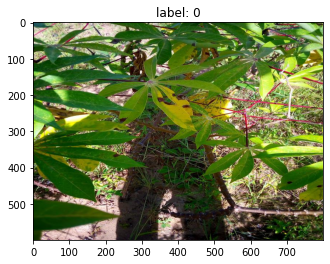

In [11]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transforms

In [12]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                CenterCrop(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

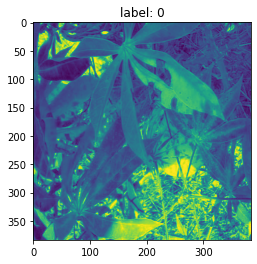

In [13]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# CutMix / FMix


In [14]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets


def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    if CFG.apex:
        # mask = torch.tensor(mask, device=device).float()
        mask = mask.astype(np.float32)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, shuffled_targets, lam)

    return (x1 + x2), targets

# MixUp

In [15]:
# https://github.com/yuhao318/mwh/blob/e9e2da8fc6/utils.py
def mixup(x, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## SYM
    # mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = (1 - lam) * x + lam * x[index,:]
    # mixed_image  = torch.cat([mixed_x,mixed_y], 0)
    # y_a, y_b = y, y[index]
    # mixed_label  = torch.cat([y_a,y_b], 0)

    ## Reduce batch size
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    ## Only Alpha
    # mixed_x = 0.5 * x + (1 - 0.5) * x[index,:]
    # mixed_image  = mixed_x
    # y_a, y_b = y, y[index]
    # ind_label = torch.randint_like(y, 0,2)
    # mixed_label  = ind_label * y_a + (1-ind_label) * y_b

    ## Reduce batch size and SYM
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j
    # mixed_y = (1 - lam) * x_i + lam * x_j
    # mixed_x  = torch.cat([mixed_x,mixed_y], 0)
    # y_b = torch.cat([y_b,y_a], 0)
    # y_a = y

    # return mixed_image, mixed_label, lam
    return mixed_x, (y_a, y_b, lam)

# MODEL

In [16]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model_name = model_name

        if model_name.startswith("deit_"):
            self.model = torch.hub.load("facebookresearch/deit:main", model_name, pretrained=True)

            if model_name == "deit_base_patch16_384":
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

        else:
            self.model = timm.create_model(model_name, pretrained=pretrained)

            if "resnext50_32x4d" in model_name:
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("tf_efficientnet"):
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("vit_"):
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

    if CFG.model_name.startswith("vit_"):
        try:
            for m in model.modules():
                if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                    m.eval()
        except ValuError:
            print("error with batchnorm2d or layernorm")
            return

In [18]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)
print(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

CassvaImgClassifier(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNor

# Loss functions

In [19]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

# Helper functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, scheduler_batch_update=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # CutMix, FMix
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            mix_decision = 0.75  # Disable CutMix, FMix for final epoch
        else:
            mix_decision = np.random.rand()

        if epoch >= CFG.epochs - 4:
            mix_decision *= 2  # Reduce probability

        if mix_decision < 0.25:
            images, labels = cutmix(images, labels, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(images, labels, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size))
        elif mix_decision >= 0.5 and mix_decision < 0.75:
            images, labels = mixup(images, labels, alpha=0.5)

        y_preds = model(images.float())

        if mix_decision < 0.75:
            loss = criterion(y_preds, labels[0]) * labels[2] + criterion(y_preds, labels[1]) * (1.0 - labels[2])
        else:
            loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if CFG.scheduler_batch_update:
                scheduler.step()

            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f} "
                "LR: {lr:.6f}  ".format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.first_cycle_steps,
                cycle_mult=1.0,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=CFG.warmup_steps,
                gamma=CFG.gamma,
            )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not CFG.apex:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            avg_loss = train_fn(
                train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )
        else:
            avg_loss = train_fn(
                train_loader, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if not CFG.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

        if epoch == CFG.epochs - 1:
            LOGGER.info(f"Epoch {epoch+1} - Save final model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_final.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [ ]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Epoch: [1][0/2633] Elapsed 0m 3s (remain 154m 37s) Loss: 0.4805(0.4805) Grad: 0.0687 LR: 0.000100  
Epoch: [1][100/2633] Elapsed 1m 28s (remain 36m 50s) Loss: 0.4374(0.4364) Grad: 0.1328 LR: 0.000100  
Epoch: [1][200/2633] Elapsed 2m 52s (remain 34m 50s) Loss: 0.1959(0.3739) Grad: 0.1350 LR: 0.000100  
Epoch: [1][300/2633] Elapsed 4m 17s (remain 33m 13s) Loss: 0.2341(0.3444) Grad: 0.0877 LR: 0.000100  
Epoch: [1][400/2633] Elapsed 5m 41s (remain 31m 42s) Loss: 0.1930(0.3266) Grad: 0.0562 LR: 0.000100  
Epoch: [1][500/2633] Elapsed 7m 6s (remain 30m 14s) Loss: 0.1429(0.3121) Grad: 0.0749 LR: 0.000100  
Epoch: [1][600/2633] Elapsed 8m 30s (remain 28m 47s) Loss: 0.3424(0.3030) Grad: 0.2447 LR: 0.000100  
Epoch: [1][700/2633] Elapsed 9m 55s (remain 27m 20s) Loss: 0.1282(0.2952) Grad: 0.1521 LR: 0.000100  
Epoch: [1][800/2633] Elapsed 11m 19s (remain 25m 54s) Loss: 0.2211(0.2888) Grad: 0.1379 LR: 0.000100  
Epoch: [1][900/2633] Elapsed 12m 44s (remain 24m 29s) Loss: 0.2228(0.2800) Grad: 0.1

Epoch 1 - avg_train_loss: 0.2006  avg_val_loss: 0.1137  time: 2389s
Epoch 1 - Accuracy: 0.8714882308276386
Epoch 1 - Save Best Score: 0.8715 Model


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.1036(0.1137) 
Epoch: [2][0/2633] Elapsed 0m 1s (remain 57m 37s) Loss: 0.0536(0.0536) Grad: 0.3624 LR: 0.000098  
Epoch: [2][100/2633] Elapsed 1m 25s (remain 35m 50s) Loss: 0.0591(0.1268) Grad: 0.2136 LR: 0.000097  
Epoch: [2][200/2633] Elapsed 2m 49s (remain 34m 16s) Loss: 0.0158(0.1243) Grad: 0.0700 LR: 0.000097  
Epoch: [2][300/2633] Elapsed 4m 14s (remain 32m 49s) Loss: 0.1703(0.1200) Grad: 0.1109 LR: 0.000097  
Epoch: [2][400/2633] Elapsed 5m 38s (remain 31m 23s) Loss: 0.2727(0.1177) Grad: 0.5100 LR: 0.000097  
Epoch: [2][500/2633] Elapsed 7m 2s (remain 29m 58s) Loss: 0.2504(0.1161) Grad: 0.3697 LR: 0.000097  
Epoch: [2][600/2633] Elapsed 8m 26s (remain 28m 33s) Loss: 0.1055(0.1169) Grad: 0.3039 LR: 0.000096  
Epoch: [2][700/2633] Elapsed 9m 51s (remain 27m 9s) Loss: 0.0189(0.1172) Grad: 0.1049 LR: 0.000096  
Epoch: [2][800/2633] Elapsed 11m 15s (remain 25m 44s) Loss: 0.1471(0.1175) Grad: 0.4569 LR: 0.000096  
Epoch: [2][900/263

Epoch 2 - avg_train_loss: 0.1156  avg_val_loss: 0.1089  time: 2380s
Epoch 2 - Accuracy: 0.8750949126803341
Epoch 2 - Save Best Score: 0.8751 Model


Epoch: [3][0/2633] Elapsed 0m 1s (remain 58m 58s) Loss: 0.0243(0.0243) Grad: 0.2527 LR: 0.000091  
Epoch: [3][100/2633] Elapsed 1m 27s (remain 36m 25s) Loss: 0.3766(0.2586) Grad: 0.3413 LR: 0.000090  
Epoch: [3][200/2633] Elapsed 2m 52s (remain 34m 51s) Loss: 0.0672(0.2472) Grad: 0.1131 LR: 0.000090  
Epoch: [3][300/2633] Elapsed 4m 18s (remain 33m 20s) Loss: 0.0291(0.2359) Grad: 0.1164 LR: 0.000090  
Epoch: [3][400/2633] Elapsed 5m 43s (remain 31m 53s) Loss: 0.3311(0.2314) Grad: 0.2035 LR: 0.000089  
Epoch: [3][500/2633] Elapsed 7m 9s (remain 30m 27s) Loss: 0.0574(0.2252) Grad: 0.2921 LR: 0.000089  
Epoch: [3][600/2633] Elapsed 8m 34s (remain 29m 0s) Loss: 0.0446(0.2218) Grad: 0.1732 LR: 0.000088  
Epoch: [3][700/2633] Elapsed 9m 59s (remain 27m 33s) Loss: 0.0486(0.2208) Grad: 0.1510 LR: 0.000088  
Epoch: [3][800/2633] Elapsed 11m 25s (remain 26m 7s) Loss: 0.2891(0.2205) Grad: 0.3351 LR: 0.000088  
Epoch: [3][900/2633] Elapsed 12m 51s (remain 24m 42s) Loss: 0.1712(0.2200) Grad: 0.2403

Epoch 3 - avg_train_loss: 0.2090  avg_val_loss: 0.1145  time: 2418s
Epoch 3 - Accuracy: 0.8720577069096431


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.0288(0.1145) 
Epoch: [4][0/2633] Elapsed 0m 1s (remain 61m 26s) Loss: 0.1243(0.1243) Grad: 0.2734 LR: 0.000080  
Epoch: [4][100/2633] Elapsed 1m 27s (remain 36m 37s) Loss: 0.1228(0.2027) Grad: 0.1363 LR: 0.000079  
Epoch: [4][200/2633] Elapsed 2m 53s (remain 35m 2s) Loss: 0.1446(0.2119) Grad: 0.1598 LR: 0.000079  
Epoch: [4][300/2633] Elapsed 4m 19s (remain 33m 34s) Loss: 0.0629(0.2123) Grad: 0.1372 LR: 0.000078  
Epoch: [4][400/2633] Elapsed 5m 45s (remain 32m 5s) Loss: 0.1475(0.2110) Grad: 0.3113 LR: 0.000078  
Epoch: [4][500/2633] Elapsed 7m 11s (remain 30m 36s) Loss: 0.1707(0.2118) Grad: 0.2592 LR: 0.000077  
Epoch: [4][600/2633] Elapsed 8m 36s (remain 29m 7s) Loss: 0.2260(0.2082) Grad: 0.1140 LR: 0.000077  
Epoch: [4][700/2633] Elapsed 10m 2s (remain 27m 40s) Loss: 0.0831(0.2060) Grad: 0.1288 LR: 0.000076  
Epoch: [4][800/2633] Elapsed 11m 28s (remain 26m 14s) Loss: 0.1224(0.2059) Grad: 0.3160 LR: 0.000076  
Epoch: [4][900/2633

Epoch 4 - avg_train_loss: 0.2005  avg_val_loss: 0.1020  time: 2423s
Epoch 4 - Accuracy: 0.884206529992407
Epoch 4 - Save Best Score: 0.8842 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1122(0.1020) 
Epoch: [5][0/2633] Elapsed 0m 1s (remain 58m 33s) Loss: 0.2547(0.2547) Grad: 0.2453 LR: 0.000066  
Epoch: [5][100/2633] Elapsed 1m 27s (remain 36m 25s) Loss: 0.1779(0.1925) Grad: 0.2216 LR: 0.000066  
Epoch: [5][200/2633] Elapsed 2m 52s (remain 34m 48s) Loss: 0.2212(0.2007) Grad: 0.1693 LR: 0.000065  
Epoch: [5][300/2633] Elapsed 4m 18s (remain 33m 23s) Loss: 0.1307(0.1937) Grad: 0.0990 LR: 0.000065  
Epoch: [5][400/2633] Elapsed 5m 44s (remain 31m 55s) Loss: 0.2037(0.1910) Grad: 0.2433 LR: 0.000064  
Epoch: [5][500/2633] Elapsed 7m 9s (remain 30m 28s) Loss: 0.0139(0.1925) Grad: 0.0554 LR: 0.000063  
Epoch: [5][600/2633] Elapsed 8m 35s (remain 29m 1s) Loss: 0.1464(0.1940) Grad: 0.1024 LR: 0.000063  
Epoch: [5][700/2633] Elapsed 10m 0s (remain 27m 35s) Loss: 0.2389(0.1939) Grad: 0.2391 LR: 0.000062  
Epoch: [5][800/2633] Elapsed 11m 26s (remain 26m 9s) Loss: 0.2884(0.1948) Grad: 0.2396 LR: 0.000062  
Epoch: [5][900/2633

Epoch 5 - avg_train_loss: 0.1936  avg_val_loss: 0.1018  time: 2416s
Epoch 5 - Accuracy: 0.8855353075170843
Epoch 5 - Save Best Score: 0.8855 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0586(0.1018) 
Epoch: [6][0/2633] Elapsed 0m 1s (remain 58m 56s) Loss: 0.1978(0.1978) Grad: 0.3928 LR: 0.000051  
Epoch: [6][100/2633] Elapsed 1m 26s (remain 36m 17s) Loss: 0.0431(0.1668) Grad: 0.1372 LR: 0.000050  
Epoch: [6][200/2633] Elapsed 2m 52s (remain 34m 46s) Loss: 0.1495(0.1840) Grad: 0.1148 LR: 0.000050  
Epoch: [6][300/2633] Elapsed 4m 18s (remain 33m 20s) Loss: 0.2693(0.1873) Grad: 0.1913 LR: 0.000049  
Epoch: [6][400/2633] Elapsed 5m 43s (remain 31m 52s) Loss: 0.1585(0.1864) Grad: 0.3355 LR: 0.000049  
Epoch: [6][500/2633] Elapsed 7m 9s (remain 30m 26s) Loss: 0.3046(0.1884) Grad: 0.1345 LR: 0.000048  
Epoch: [6][600/2633] Elapsed 8m 34s (remain 28m 59s) Loss: 0.1816(0.1891) Grad: 0.0960 LR: 0.000048  
Epoch: [6][700/2633] Elapsed 10m 0s (remain 27m 34s) Loss: 0.1742(0.1914) Grad: 0.2619 LR: 0.000047  
Epoch: [6][800/2633] Elapsed 11m 26s (remain 26m 9s) Loss: 0.0956(0.1889) Grad: 0.1169 LR: 0.000046  
Epoch: [6][900/263

Epoch 6 - avg_train_loss: 0.1879  avg_val_loss: 0.1061  time: 2416s
Epoch 6 - Accuracy: 0.880030372057707


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.1261(0.1061) 
Epoch: [7][0/2633] Elapsed 0m 1s (remain 59m 17s) Loss: 0.0590(0.0590) Grad: 0.3308 LR: 0.000036  
Epoch: [7][100/2633] Elapsed 1m 26s (remain 36m 7s) Loss: 0.2513(0.1458) Grad: 0.2668 LR: 0.000035  
Epoch: [7][200/2633] Elapsed 2m 51s (remain 34m 35s) Loss: 0.1069(0.1517) Grad: 0.1389 LR: 0.000035  
Epoch: [7][300/2633] Elapsed 4m 16s (remain 33m 8s) Loss: 0.1791(0.1575) Grad: 0.1902 LR: 0.000034  
Epoch: [7][400/2633] Elapsed 5m 41s (remain 31m 42s) Loss: 0.0639(0.1523) Grad: 0.2544 LR: 0.000034  
Epoch: [7][500/2633] Elapsed 7m 6s (remain 30m 16s) Loss: 0.1925(0.1524) Grad: 0.2112 LR: 0.000033  
Epoch: [7][600/2633] Elapsed 8m 32s (remain 28m 51s) Loss: 0.2166(0.1517) Grad: 0.2049 LR: 0.000033  
Epoch: [7][700/2633] Elapsed 9m 57s (remain 27m 25s) Loss: 0.0391(0.1510) Grad: 0.2377 LR: 0.000032  
Epoch: [7][800/2633] Elapsed 11m 22s (remain 26m 0s) Loss: 0.0797(0.1494) Grad: 0.0708 LR: 0.000032  
Epoch: [7][900/2633]

Epoch 7 - avg_train_loss: 0.1488  avg_val_loss: 0.1012  time: 2401s
Epoch 7 - Accuracy: 0.8853454821564161


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1004(0.1012) 
Epoch: [8][0/2633] Elapsed 0m 1s (remain 58m 42s) Loss: 0.3028(0.3028) Grad: 0.3932 LR: 0.000022  
Epoch: [8][100/2633] Elapsed 1m 26s (remain 36m 2s) Loss: 0.0747(0.1445) Grad: 0.2561 LR: 0.000022  
Epoch: [8][200/2633] Elapsed 2m 51s (remain 34m 36s) Loss: 0.0173(0.1504) Grad: 0.0877 LR: 0.000021  
Epoch: [8][300/2633] Elapsed 4m 16s (remain 33m 9s) Loss: 0.0649(0.1482) Grad: 0.0342 LR: 0.000021  
Epoch: [8][400/2633] Elapsed 5m 41s (remain 31m 41s) Loss: 0.4067(0.1468) Grad: 0.3456 LR: 0.000020  
Epoch: [8][500/2633] Elapsed 7m 6s (remain 30m 16s) Loss: 0.2089(0.1462) Grad: 0.2705 LR: 0.000020  
Epoch: [8][600/2633] Elapsed 8m 31s (remain 28m 50s) Loss: 0.2365(0.1444) Grad: 0.2042 LR: 0.000020  
Epoch: [8][700/2633] Elapsed 9m 56s (remain 27m 24s) Loss: 0.0940(0.1436) Grad: 0.2345 LR: 0.000019  
Epoch: [8][800/2633] Elapsed 11m 21s (remain 25m 59s) Loss: 0.2239(0.1423) Grad: 0.2456 LR: 0.000019  
Epoch: [8][900/2633

Epoch 8 - avg_train_loss: 0.1425  avg_val_loss: 0.0999  time: 2400s
Epoch 8 - Accuracy: 0.8834472285497342


Epoch: [9][0/2633] Elapsed 0m 1s (remain 59m 28s) Loss: 0.2732(0.2732) Grad: 0.5421 LR: 0.000011  
Epoch: [9][100/2633] Elapsed 1m 26s (remain 36m 6s) Loss: 0.2070(0.1571) Grad: 0.2289 LR: 0.000011  
Epoch: [9][200/2633] Elapsed 2m 51s (remain 34m 37s) Loss: 0.1980(0.1546) Grad: 0.3424 LR: 0.000011  
Epoch: [9][300/2633] Elapsed 4m 16s (remain 33m 9s) Loss: 0.0090(0.1533) Grad: 0.0542 LR: 0.000010  
Epoch: [9][400/2633] Elapsed 5m 41s (remain 31m 43s) Loss: 0.2918(0.1544) Grad: 0.5391 LR: 0.000010  
Epoch: [9][500/2633] Elapsed 7m 7s (remain 30m 18s) Loss: 0.0750(0.1506) Grad: 0.2428 LR: 0.000010  
Epoch: [9][600/2633] Elapsed 8m 32s (remain 28m 52s) Loss: 0.1283(0.1475) Grad: 0.4680 LR: 0.000009  
Epoch: [9][700/2633] Elapsed 9m 57s (remain 27m 27s) Loss: 0.0238(0.1473) Grad: 0.1280 LR: 0.000009  
Epoch: [9][800/2633] Elapsed 11m 22s (remain 26m 1s) Loss: 0.2433(0.1485) Grad: 0.4101 LR: 0.000009  
Epoch: [9][900/2633] Elapsed 12m 47s (remain 24m 36s) Loss: 0.1354(0.1478) Grad: 0.2740 

Epoch 9 - avg_train_loss: 0.1457  avg_val_loss: 0.1036  time: 2405s
Epoch 9 - Accuracy: 0.8802201974183751


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.0568(0.1036) 
Epoch: [10][0/2633] Elapsed 0m 1s (remain 58m 3s) Loss: 0.0239(0.0239) Grad: 0.1581 LR: 0.000004  
Epoch: [10][100/2633] Elapsed 1m 25s (remain 35m 53s) Loss: 0.2076(0.0862) Grad: 0.4942 LR: 0.000004  
Epoch: [10][200/2633] Elapsed 2m 50s (remain 34m 21s) Loss: 0.1022(0.0847) Grad: 0.1717 LR: 0.000004  
Epoch: [10][300/2633] Elapsed 4m 14s (remain 32m 54s) Loss: 0.1404(0.0827) Grad: 0.1641 LR: 0.000004  
Epoch: [10][400/2633] Elapsed 5m 39s (remain 31m 29s) Loss: 0.0497(0.0843) Grad: 0.1885 LR: 0.000004  
Epoch: [10][500/2633] Elapsed 7m 3s (remain 30m 3s) Loss: 0.0941(0.0836) Grad: 0.2156 LR: 0.000004  
Epoch: [10][600/2633] Elapsed 8m 28s (remain 28m 38s) Loss: 0.0114(0.0835) Grad: 0.0425 LR: 0.000003  
Epoch: [10][700/2633] Elapsed 9m 52s (remain 27m 13s) Loss: 0.0196(0.0829) Grad: 0.1194 LR: 0.000003  
Epoch: [10][800/2633] Elapsed 11m 17s (remain 25m 49s) Loss: 0.2366(0.0825) Grad: 0.4819 LR: 0.000003  
Epoch: [10

Epoch 10 - avg_train_loss: 0.0814  avg_val_loss: 0.0975  time: 2386s
Epoch 10 - Accuracy: 0.8872437357630979
Epoch 10 - Save Best Score: 0.8872 Model


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.0314(0.0975) 


Epoch 10 - Save final model
========== fold: 0 result ==========
Score: 0.88724
========== fold: 1 training ==========


Epoch: [1][0/2633] Elapsed 0m 1s (remain 58m 7s) Loss: 0.4772(0.4772) Grad: 0.0732 LR: 0.000100  
Epoch: [1][100/2633] Elapsed 1m 25s (remain 35m 52s) Loss: 0.3778(0.4409) Grad: 0.1035 LR: 0.000100  
Epoch: [1][200/2633] Elapsed 2m 50s (remain 34m 19s) Loss: 0.3369(0.3809) Grad: 0.1408 LR: 0.000100  
Epoch: [1][300/2633] Elapsed 4m 14s (remain 32m 51s) Loss: 0.1230(0.3457) Grad: 0.1717 LR: 0.000100  
Epoch: [1][400/2633] Elapsed 5m 38s (remain 31m 25s) Loss: 0.3216(0.3287) Grad: 0.1308 LR: 0.000100  
Epoch: [1][500/2633] Elapsed 7m 3s (remain 30m 0s) Loss: 0.2148(0.3131) Grad: 0.0635 LR: 0.000100  
Epoch: [1][600/2633] Elapsed 8m 27s (remain 28m 35s) Loss: 0.1745(0.3022) Grad: 0.0720 LR: 0.000100  
Epoch: [1][700/2633] Elapsed 9m 51s (remain 27m 10s) Loss: 0.3070(0.2934) Grad: 0.1630 LR: 0.000100  
Epoch: [1][800/2633] Elapsed 11m 15s (remain 25m 45s) Loss: 0.5363(0.2843) Grad: 0.1307 LR: 0.000100  
Epoch: [1][900/2633] Elapsed 12m 40s (remain 24m 21s) Loss: 0.3836(0.2773) Grad: 0.2737

Epoch 1 - avg_train_loss: 0.2001  avg_val_loss: 0.1482  time: 2382s
Epoch 1 - Accuracy: 0.8420652999240699
Epoch 1 - Save Best Score: 0.8421 Model


Epoch: [2][0/2633] Elapsed 0m 1s (remain 57m 40s) Loss: 0.0241(0.0241) Grad: 0.5676 LR: 0.000098  
Epoch: [2][100/2633] Elapsed 1m 25s (remain 35m 47s) Loss: 0.1587(0.1175) Grad: 0.3448 LR: 0.000097  
Epoch: [2][200/2633] Elapsed 2m 49s (remain 34m 15s) Loss: 0.2329(0.1207) Grad: 0.5368 LR: 0.000097  
Epoch: [2][300/2633] Elapsed 4m 14s (remain 32m 49s) Loss: 0.0185(0.1188) Grad: 0.0781 LR: 0.000097  
Epoch: [2][400/2633] Elapsed 5m 38s (remain 31m 25s) Loss: 0.1266(0.1178) Grad: 0.3666 LR: 0.000097  
Epoch: [2][500/2633] Elapsed 7m 3s (remain 30m 1s) Loss: 0.1959(0.1180) Grad: 0.4959 LR: 0.000097  
Epoch: [2][600/2633] Elapsed 8m 27s (remain 28m 36s) Loss: 0.1321(0.1188) Grad: 0.0732 LR: 0.000096  
Epoch: [2][700/2633] Elapsed 9m 52s (remain 27m 12s) Loss: 0.0207(0.1213) Grad: 0.2114 LR: 0.000096  
Epoch: [2][800/2633] Elapsed 11m 16s (remain 25m 47s) Loss: 0.1895(0.1223) Grad: 0.2767 LR: 0.000096  
Epoch: [2][900/2633] Elapsed 12m 41s (remain 24m 23s) Loss: 0.1518(0.1225) Grad: 0.298

Epoch 2 - avg_train_loss: 0.1160  avg_val_loss: 0.1674  time: 2387s
Epoch 2 - Accuracy: 0.8031511009870919


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.3884(0.1674) 
Epoch: [3][0/2633] Elapsed 0m 1s (remain 60m 20s) Loss: 0.2938(0.2938) Grad: 0.6214 LR: 0.000091  
Epoch: [3][100/2633] Elapsed 1m 26s (remain 36m 19s) Loss: 0.2331(0.2256) Grad: 0.2800 LR: 0.000090  
Epoch: [3][200/2633] Elapsed 2m 52s (remain 34m 48s) Loss: 0.0338(0.2284) Grad: 0.1790 LR: 0.000090  
Epoch: [3][300/2633] Elapsed 4m 18s (remain 33m 20s) Loss: 0.0227(0.2332) Grad: 0.0836 LR: 0.000090  
Epoch: [3][400/2633] Elapsed 5m 43s (remain 31m 54s) Loss: 0.1533(0.2252) Grad: 0.2054 LR: 0.000089  
Epoch: [3][500/2633] Elapsed 7m 9s (remain 30m 28s) Loss: 0.2332(0.2224) Grad: 0.0899 LR: 0.000089  
Epoch: [3][600/2633] Elapsed 8m 35s (remain 29m 2s) Loss: 0.0492(0.2216) Grad: 0.1703 LR: 0.000088  
Epoch: [3][700/2633] Elapsed 10m 1s (remain 27m 36s) Loss: 0.1267(0.2209) Grad: 0.2709 LR: 0.000088  
Epoch: [3][800/2633] Elapsed 11m 26s (remain 26m 10s) Loss: 0.2075(0.2218) Grad: 0.3411 LR: 0.000088  
Epoch: [3][900/263

Epoch 3 - avg_train_loss: 0.2145  avg_val_loss: 0.1217  time: 2419s
Epoch 3 - Accuracy: 0.8652239939255885
Epoch 3 - Save Best Score: 0.8652 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0222(0.1217) 
Epoch: [4][0/2633] Elapsed 0m 1s (remain 59m 40s) Loss: 0.1991(0.1991) Grad: 0.2560 LR: 0.000080  
Epoch: [4][100/2633] Elapsed 1m 27s (remain 36m 26s) Loss: 0.2635(0.2221) Grad: 0.1793 LR: 0.000079  
Epoch: [4][200/2633] Elapsed 2m 53s (remain 34m 53s) Loss: 0.0829(0.2056) Grad: 0.2461 LR: 0.000079  
Epoch: [4][300/2633] Elapsed 4m 18s (remain 33m 26s) Loss: 0.1146(0.2079) Grad: 0.2804 LR: 0.000078  
Epoch: [4][400/2633] Elapsed 5m 44s (remain 31m 59s) Loss: 0.0710(0.2086) Grad: 0.2301 LR: 0.000078  
Epoch: [4][500/2633] Elapsed 7m 10s (remain 30m 33s) Loss: 0.2555(0.2033) Grad: 0.4555 LR: 0.000077  
Epoch: [4][600/2633] Elapsed 8m 36s (remain 29m 5s) Loss: 0.2217(0.2057) Grad: 0.4182 LR: 0.000077  
Epoch: [4][700/2633] Elapsed 10m 2s (remain 27m 39s) Loss: 0.1556(0.2043) Grad: 0.0976 LR: 0.000076  
Epoch: [4][800/2633] Elapsed 11m 27s (remain 26m 13s) Loss: 0.0265(0.2047) Grad: 0.0575 LR: 0.000076  
Epoch: [4][900/26

Epoch 4 - avg_train_loss: 0.2002  avg_val_loss: 0.1139  time: 2422s
Epoch 4 - Accuracy: 0.8735763097949886
Epoch 4 - Save Best Score: 0.8736 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1297(0.1139) 
Epoch: [5][0/2633] Elapsed 0m 1s (remain 61m 34s) Loss: 0.2320(0.2320) Grad: 0.2455 LR: 0.000066  
Epoch: [5][100/2633] Elapsed 1m 27s (remain 36m 25s) Loss: 0.1708(0.1970) Grad: 0.2153 LR: 0.000066  
Epoch: [5][200/2633] Elapsed 2m 53s (remain 34m 55s) Loss: 0.1998(0.2037) Grad: 0.2282 LR: 0.000065  
Epoch: [5][300/2633] Elapsed 4m 18s (remain 33m 25s) Loss: 0.2285(0.2060) Grad: 0.1038 LR: 0.000065  
Epoch: [5][400/2633] Elapsed 5m 44s (remain 31m 57s) Loss: 0.1316(0.2010) Grad: 0.2870 LR: 0.000064  
Epoch: [5][500/2633] Elapsed 7m 10s (remain 30m 30s) Loss: 0.1586(0.1985) Grad: 0.2366 LR: 0.000063  
Epoch: [5][600/2633] Elapsed 8m 36s (remain 29m 5s) Loss: 0.1180(0.1958) Grad: 0.4474 LR: 0.000063  
Epoch: [5][700/2633] Elapsed 10m 2s (remain 27m 39s) Loss: 0.4407(0.1948) Grad: 0.1555 LR: 0.000062  
Epoch: [5][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.1708(0.1933) Grad: 0.2557 LR: 0.000062  
Epoch: [5][900/26

Epoch 5 - avg_train_loss: 0.1915  avg_val_loss: 0.1107  time: 2420s
Epoch 5 - Accuracy: 0.8711085801063022


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0342(0.1107) 
Epoch: [6][0/2633] Elapsed 0m 1s (remain 59m 49s) Loss: 0.1575(0.1575) Grad: 0.3173 LR: 0.000051  
Epoch: [6][100/2633] Elapsed 1m 27s (remain 36m 28s) Loss: 0.2323(0.2034) Grad: 0.1674 LR: 0.000050  
Epoch: [6][200/2633] Elapsed 2m 53s (remain 34m 55s) Loss: 0.1233(0.1945) Grad: 0.3632 LR: 0.000050  
Epoch: [6][300/2633] Elapsed 4m 19s (remain 33m 27s) Loss: 0.2941(0.1941) Grad: 0.1438 LR: 0.000049  
Epoch: [6][400/2633] Elapsed 5m 44s (remain 31m 59s) Loss: 0.2528(0.1918) Grad: 0.1887 LR: 0.000049  
Epoch: [6][500/2633] Elapsed 7m 10s (remain 30m 31s) Loss: 0.1067(0.1912) Grad: 0.1755 LR: 0.000048  
Epoch: [6][600/2633] Elapsed 8m 35s (remain 29m 3s) Loss: 0.0777(0.1920) Grad: 0.2180 LR: 0.000048  
Epoch: [6][700/2633] Elapsed 10m 1s (remain 27m 37s) Loss: 0.1753(0.1894) Grad: 0.1781 LR: 0.000047  
Epoch: [6][800/2633] Elapsed 11m 26s (remain 26m 10s) Loss: 0.1316(0.1908) Grad: 0.3470 LR: 0.000046  
Epoch: [6][900/26

Epoch 6 - avg_train_loss: 0.1887  avg_val_loss: 0.1117  time: 2417s
Epoch 6 - Accuracy: 0.876993166287016
Epoch 6 - Save Best Score: 0.8770 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0741(0.1117) 
Epoch: [7][0/2633] Elapsed 0m 1s (remain 59m 57s) Loss: 0.0958(0.0958) Grad: 0.4030 LR: 0.000036  
Epoch: [7][100/2633] Elapsed 1m 26s (remain 36m 7s) Loss: 0.3426(0.1569) Grad: 0.2698 LR: 0.000035  
Epoch: [7][200/2633] Elapsed 2m 51s (remain 34m 40s) Loss: 0.2212(0.1492) Grad: 0.1246 LR: 0.000035  
Epoch: [7][300/2633] Elapsed 4m 17s (remain 33m 11s) Loss: 0.3060(0.1480) Grad: 0.2624 LR: 0.000034  
Epoch: [7][400/2633] Elapsed 5m 42s (remain 31m 45s) Loss: 0.0333(0.1500) Grad: 0.1750 LR: 0.000034  
Epoch: [7][500/2633] Elapsed 7m 7s (remain 30m 19s) Loss: 0.1247(0.1496) Grad: 0.1088 LR: 0.000033  
Epoch: [7][600/2633] Elapsed 8m 33s (remain 28m 54s) Loss: 0.0309(0.1489) Grad: 0.1406 LR: 0.000033  
Epoch: [7][700/2633] Elapsed 9m 58s (remain 27m 28s) Loss: 0.2021(0.1477) Grad: 0.0562 LR: 0.000032  
Epoch: [7][800/2633] Elapsed 11m 23s (remain 26m 2s) Loss: 0.0773(0.1472) Grad: 0.1580 LR: 0.000032  
Epoch: [7][900/2633

Epoch 7 - avg_train_loss: 0.1469  avg_val_loss: 0.1123  time: 2404s
Epoch 7 - Accuracy: 0.8762338648443432


Epoch: [8][0/2633] Elapsed 0m 1s (remain 60m 20s) Loss: 0.0394(0.0394) Grad: 0.3942 LR: 0.000022  
Epoch: [8][100/2633] Elapsed 1m 26s (remain 36m 10s) Loss: 0.0947(0.1269) Grad: 0.2283 LR: 0.000022  
Epoch: [8][200/2633] Elapsed 2m 52s (remain 34m 42s) Loss: 0.1451(0.1370) Grad: 0.3142 LR: 0.000021  
Epoch: [8][300/2633] Elapsed 4m 17s (remain 33m 15s) Loss: 0.1179(0.1456) Grad: 0.4005 LR: 0.000021  
Epoch: [8][400/2633] Elapsed 5m 42s (remain 31m 47s) Loss: 0.4142(0.1479) Grad: 0.2540 LR: 0.000020  
Epoch: [8][500/2633] Elapsed 7m 7s (remain 30m 21s) Loss: 0.1476(0.1464) Grad: 0.1781 LR: 0.000020  
Epoch: [8][600/2633] Elapsed 8m 32s (remain 28m 54s) Loss: 0.0721(0.1451) Grad: 0.2308 LR: 0.000020  
Epoch: [8][700/2633] Elapsed 9m 58s (remain 27m 30s) Loss: 0.0495(0.1476) Grad: 0.3214 LR: 0.000019  
Epoch: [8][800/2633] Elapsed 11m 24s (remain 26m 4s) Loss: 0.2660(0.1473) Grad: 0.1342 LR: 0.000019  
Epoch: [8][900/2633] Elapsed 12m 49s (remain 24m 39s) Loss: 0.1349(0.1465) Grad: 0.394

Epoch 8 - avg_train_loss: 0.1459  avg_val_loss: 0.1035  time: 2409s
Epoch 8 - Accuracy: 0.8802201974183751
Epoch 8 - Save Best Score: 0.8802 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0727(0.1035) 
Epoch: [9][0/2633] Elapsed 0m 1s (remain 59m 57s) Loss: 0.0198(0.0198) Grad: 0.1941 LR: 0.000011  
Epoch: [9][100/2633] Elapsed 1m 26s (remain 36m 19s) Loss: 0.2089(0.1315) Grad: 0.4260 LR: 0.000011  
Epoch: [9][200/2633] Elapsed 2m 52s (remain 34m 46s) Loss: 0.1051(0.1504) Grad: 0.3630 LR: 0.000011  
Epoch: [9][300/2633] Elapsed 4m 17s (remain 33m 16s) Loss: 0.1995(0.1508) Grad: 0.3355 LR: 0.000010  
Epoch: [9][400/2633] Elapsed 5m 42s (remain 31m 48s) Loss: 0.3097(0.1492) Grad: 0.2461 LR: 0.000010  
Epoch: [9][500/2633] Elapsed 7m 8s (remain 30m 22s) Loss: 0.0710(0.1487) Grad: 0.2608 LR: 0.000010  
Epoch: [9][600/2633] Elapsed 8m 33s (remain 28m 56s) Loss: 0.0760(0.1482) Grad: 0.3125 LR: 0.000009  
Epoch: [9][700/2633] Elapsed 9m 58s (remain 27m 30s) Loss: 0.0090(0.1463) Grad: 0.0468 LR: 0.000009  
Epoch: [9][800/2633] Elapsed 11m 24s (remain 26m 4s) Loss: 0.1417(0.1440) Grad: 0.3397 LR: 0.000009  
Epoch: [9][900/263

Epoch 9 - avg_train_loss: 0.1449  avg_val_loss: 0.1097  time: 2408s
Epoch 9 - Accuracy: 0.8752847380410023


Epoch: [10][0/2633] Elapsed 0m 1s (remain 58m 19s) Loss: 0.0181(0.0181) Grad: 0.3127 LR: 0.000004  
Epoch: [10][100/2633] Elapsed 1m 25s (remain 35m 50s) Loss: 0.0558(0.0866) Grad: 0.2331 LR: 0.000004  
Epoch: [10][200/2633] Elapsed 2m 50s (remain 34m 19s) Loss: 0.0770(0.0831) Grad: 0.2972 LR: 0.000004  
Epoch: [10][300/2633] Elapsed 4m 14s (remain 32m 52s) Loss: 0.1229(0.0846) Grad: 0.2077 LR: 0.000004  
Epoch: [10][400/2633] Elapsed 5m 38s (remain 31m 26s) Loss: 0.2107(0.0805) Grad: 0.2634 LR: 0.000004  
Epoch: [10][500/2633] Elapsed 7m 3s (remain 30m 1s) Loss: 0.0240(0.0804) Grad: 0.0996 LR: 0.000004  
Epoch: [10][600/2633] Elapsed 8m 27s (remain 28m 36s) Loss: 0.1535(0.0797) Grad: 0.0942 LR: 0.000003  
Epoch: [10][700/2633] Elapsed 9m 52s (remain 27m 12s) Loss: 0.1292(0.0793) Grad: 0.2412 LR: 0.000003  
Epoch: [10][800/2633] Elapsed 11m 16s (remain 25m 47s) Loss: 0.0065(0.0795) Grad: 0.0285 LR: 0.000003  
Epoch: [10][900/2633] Elapsed 12m 40s (remain 24m 22s) Loss: 0.0825(0.0800) G

Epoch 10 - avg_train_loss: 0.0825  avg_val_loss: 0.1055  time: 2382s
Epoch 10 - Accuracy: 0.8764236902050114
Epoch 10 - Save final model


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.1093(0.1055) 


========== fold: 1 result ==========
Score: 0.88022
========== fold: 2 training ==========


Epoch: [1][0/2633] Elapsed 0m 1s (remain 58m 11s) Loss: 0.4785(0.4785) Grad: 0.0557 LR: 0.000100  
Epoch: [1][100/2633] Elapsed 1m 25s (remain 35m 53s) Loss: 0.3818(0.4405) Grad: 0.1349 LR: 0.000100  
Epoch: [1][200/2633] Elapsed 2m 50s (remain 34m 22s) Loss: 0.2868(0.3845) Grad: 0.1832 LR: 0.000100  
Epoch: [1][300/2633] Elapsed 4m 15s (remain 32m 55s) Loss: 0.1404(0.3468) Grad: 0.1593 LR: 0.000100  
Epoch: [1][400/2633] Elapsed 5m 39s (remain 31m 29s) Loss: 0.2918(0.3222) Grad: 0.1693 LR: 0.000100  
Epoch: [1][500/2633] Elapsed 7m 4s (remain 30m 4s) Loss: 0.1627(0.3062) Grad: 0.2086 LR: 0.000100  
Epoch: [1][600/2633] Elapsed 8m 28s (remain 28m 39s) Loss: 0.2983(0.2933) Grad: 0.2192 LR: 0.000100  
Epoch: [1][700/2633] Elapsed 9m 53s (remain 27m 14s) Loss: 0.1865(0.2824) Grad: 0.2612 LR: 0.000100  
Epoch: [1][800/2633] Elapsed 11m 17s (remain 25m 49s) Loss: 0.0898(0.2734) Grad: 0.1607 LR: 0.000100  
Epoch: [1][900/2633] Elapsed 12m 42s (remain 24m 25s) Loss: 0.1482(0.2653) Grad: 0.284

Epoch 1 - avg_train_loss: 0.1937  avg_val_loss: 0.1239  time: 2388s
Epoch 1 - Accuracy: 0.8553256123030188
Epoch 1 - Save Best Score: 0.8553 Model


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.0307(0.1239) 
Epoch: [2][0/2633] Elapsed 0m 1s (remain 57m 43s) Loss: 0.1122(0.1122) Grad: 0.4970 LR: 0.000098  
Epoch: [2][100/2633] Elapsed 1m 25s (remain 35m 48s) Loss: 0.1910(0.1076) Grad: 0.4923 LR: 0.000097  
Epoch: [2][200/2633] Elapsed 2m 50s (remain 34m 18s) Loss: 0.1050(0.1166) Grad: 0.3966 LR: 0.000097  
Epoch: [2][300/2633] Elapsed 4m 14s (remain 32m 52s) Loss: 0.1311(0.1174) Grad: 0.1986 LR: 0.000097  
Epoch: [2][400/2633] Elapsed 5m 39s (remain 31m 27s) Loss: 0.2301(0.1211) Grad: 0.4070 LR: 0.000097  
Epoch: [2][500/2633] Elapsed 7m 3s (remain 30m 1s) Loss: 0.1949(0.1239) Grad: 0.4949 LR: 0.000097  
Epoch: [2][600/2633] Elapsed 8m 27s (remain 28m 36s) Loss: 0.0843(0.1237) Grad: 0.4235 LR: 0.000096  
Epoch: [2][700/2633] Elapsed 9m 52s (remain 27m 12s) Loss: 0.3469(0.1221) Grad: 0.4120 LR: 0.000096  
Epoch: [2][800/2633] Elapsed 11m 16s (remain 25m 47s) Loss: 0.3164(0.1215) Grad: 0.5702 LR: 0.000096  
Epoch: [2][900/263

Epoch 2 - avg_train_loss: 0.1171  avg_val_loss: 0.1097  time: 2384s
Epoch 2 - Accuracy: 0.8760205050313271
Epoch 2 - Save Best Score: 0.8760 Model


Epoch: [3][0/2633] Elapsed 0m 1s (remain 59m 35s) Loss: 0.3006(0.3006) Grad: 0.6478 LR: 0.000091  
Epoch: [3][100/2633] Elapsed 1m 27s (remain 36m 31s) Loss: 0.0470(0.2503) Grad: 0.2451 LR: 0.000090  
Epoch: [3][200/2633] Elapsed 2m 53s (remain 34m 53s) Loss: 0.0377(0.2488) Grad: 0.2026 LR: 0.000090  
Epoch: [3][300/2633] Elapsed 4m 18s (remain 33m 23s) Loss: 0.3038(0.2388) Grad: 0.2989 LR: 0.000090  
Epoch: [3][400/2633] Elapsed 5m 43s (remain 31m 54s) Loss: 0.1640(0.2309) Grad: 0.2840 LR: 0.000089  
Epoch: [3][500/2633] Elapsed 7m 9s (remain 30m 26s) Loss: 0.2830(0.2277) Grad: 0.4979 LR: 0.000089  
Epoch: [3][600/2633] Elapsed 8m 34s (remain 28m 59s) Loss: 0.1270(0.2229) Grad: 0.2480 LR: 0.000088  
Epoch: [3][700/2633] Elapsed 10m 0s (remain 27m 33s) Loss: 0.1380(0.2235) Grad: 0.3559 LR: 0.000088  
Epoch: [3][800/2633] Elapsed 11m 25s (remain 26m 7s) Loss: 0.3421(0.2210) Grad: 0.2111 LR: 0.000088  
Epoch: [3][900/2633] Elapsed 12m 50s (remain 24m 41s) Loss: 0.2014(0.2189) Grad: 0.215

Epoch 3 - avg_train_loss: 0.2117  avg_val_loss: 0.1155  time: 2415s
Epoch 3 - Accuracy: 0.868995633187773


Epoch: [4][0/2633] Elapsed 0m 1s (remain 62m 8s) Loss: 0.1079(0.1079) Grad: 0.2400 LR: 0.000080  
Epoch: [4][100/2633] Elapsed 1m 27s (remain 36m 23s) Loss: 0.1149(0.2178) Grad: 0.3515 LR: 0.000079  
Epoch: [4][200/2633] Elapsed 2m 52s (remain 34m 49s) Loss: 0.3922(0.2121) Grad: 0.2466 LR: 0.000079  
Epoch: [4][300/2633] Elapsed 4m 18s (remain 33m 24s) Loss: 0.2277(0.2086) Grad: 0.0856 LR: 0.000078  
Epoch: [4][400/2633] Elapsed 5m 44s (remain 31m 59s) Loss: 0.2544(0.2070) Grad: 0.1195 LR: 0.000078  
Epoch: [4][500/2633] Elapsed 7m 10s (remain 30m 32s) Loss: 0.3787(0.2059) Grad: 0.2354 LR: 0.000077  
Epoch: [4][600/2633] Elapsed 8m 36s (remain 29m 5s) Loss: 0.1989(0.2043) Grad: 0.3642 LR: 0.000077  
Epoch: [4][700/2633] Elapsed 10m 1s (remain 27m 39s) Loss: 0.0191(0.2028) Grad: 0.0590 LR: 0.000076  
Epoch: [4][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.2057(0.2021) Grad: 0.1463 LR: 0.000076  
Epoch: [4][900/2633] Elapsed 12m 53s (remain 24m 46s) Loss: 0.3615(0.2017) Grad: 0.103

Epoch 4 - avg_train_loss: 0.1992  avg_val_loss: 0.1052  time: 2420s
Epoch 4 - Accuracy: 0.8807670400607557
Epoch 4 - Save Best Score: 0.8808 Model


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.0420(0.1052) 
Epoch: [5][0/2633] Elapsed 0m 1s (remain 59m 19s) Loss: 0.3499(0.3499) Grad: 0.3840 LR: 0.000066  
Epoch: [5][100/2633] Elapsed 1m 27s (remain 36m 24s) Loss: 0.2747(0.2026) Grad: 0.2054 LR: 0.000066  
Epoch: [5][200/2633] Elapsed 2m 52s (remain 34m 49s) Loss: 0.2026(0.1990) Grad: 0.4704 LR: 0.000065  
Epoch: [5][300/2633] Elapsed 4m 18s (remain 33m 24s) Loss: 0.0718(0.1950) Grad: 0.0370 LR: 0.000065  
Epoch: [5][400/2633] Elapsed 5m 44s (remain 31m 55s) Loss: 0.1770(0.1979) Grad: 0.2884 LR: 0.000064  
Epoch: [5][500/2633] Elapsed 7m 9s (remain 30m 29s) Loss: 0.2191(0.1960) Grad: 0.2514 LR: 0.000063  
Epoch: [5][600/2633] Elapsed 8m 35s (remain 29m 4s) Loss: 0.1869(0.1986) Grad: 0.3805 LR: 0.000063  
Epoch: [5][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.2321(0.1994) Grad: 0.3777 LR: 0.000062  
Epoch: [5][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.2939(0.1987) Grad: 0.1084 LR: 0.000062  
Epoch: [5][900/263

Epoch 5 - avg_train_loss: 0.1944  avg_val_loss: 0.1198  time: 2423s
Epoch 5 - Accuracy: 0.8775393962407443


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1643(0.1198) 
Epoch: [6][0/2633] Elapsed 0m 1s (remain 59m 50s) Loss: 0.1902(0.1902) Grad: 0.3714 LR: 0.000051  
Epoch: [6][100/2633] Elapsed 1m 27s (remain 36m 26s) Loss: 0.3019(0.1964) Grad: 0.1949 LR: 0.000050  
Epoch: [6][200/2633] Elapsed 2m 52s (remain 34m 50s) Loss: 0.0515(0.2002) Grad: 0.1765 LR: 0.000050  
Epoch: [6][300/2633] Elapsed 4m 18s (remain 33m 21s) Loss: 0.1578(0.1967) Grad: 0.3068 LR: 0.000049  
Epoch: [6][400/2633] Elapsed 5m 43s (remain 31m 54s) Loss: 0.1740(0.1941) Grad: 0.2752 LR: 0.000049  
Epoch: [6][500/2633] Elapsed 7m 9s (remain 30m 29s) Loss: 0.2088(0.1913) Grad: 0.1564 LR: 0.000048  
Epoch: [6][600/2633] Elapsed 8m 36s (remain 29m 4s) Loss: 0.1527(0.1942) Grad: 0.4098 LR: 0.000048  
Epoch: [6][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.2562(0.1929) Grad: 0.1112 LR: 0.000047  
Epoch: [6][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.3823(0.1937) Grad: 0.2748 LR: 0.000046  
Epoch: [6][900/263

Epoch 6 - avg_train_loss: 0.1900  avg_val_loss: 0.1126  time: 2422s
Epoch 6 - Accuracy: 0.8811467628631099
Epoch 6 - Save Best Score: 0.8811 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1317(0.1126) 
Epoch: [7][0/2633] Elapsed 0m 1s (remain 60m 0s) Loss: 0.3508(0.3508) Grad: 0.2528 LR: 0.000036  
Epoch: [7][100/2633] Elapsed 1m 26s (remain 36m 16s) Loss: 0.3752(0.1505) Grad: 0.1981 LR: 0.000035  
Epoch: [7][200/2633] Elapsed 2m 51s (remain 34m 41s) Loss: 0.3101(0.1554) Grad: 0.1953 LR: 0.000035  
Epoch: [7][300/2633] Elapsed 4m 17s (remain 33m 13s) Loss: 0.1168(0.1540) Grad: 0.2696 LR: 0.000034  
Epoch: [7][400/2633] Elapsed 5m 42s (remain 31m 45s) Loss: 0.1161(0.1545) Grad: 0.1981 LR: 0.000034  
Epoch: [7][500/2633] Elapsed 7m 7s (remain 30m 20s) Loss: 0.0600(0.1513) Grad: 0.1089 LR: 0.000033  
Epoch: [7][600/2633] Elapsed 8m 33s (remain 28m 54s) Loss: 0.1438(0.1524) Grad: 0.2354 LR: 0.000033  
Epoch: [7][700/2633] Elapsed 9m 58s (remain 27m 28s) Loss: 0.1785(0.1537) Grad: 0.0797 LR: 0.000032  
Epoch: [7][800/2633] Elapsed 11m 23s (remain 26m 2s) Loss: 0.0596(0.1514) Grad: 0.2766 LR: 0.000032  
Epoch: [7][900/2633

Epoch 7 - avg_train_loss: 0.1511  avg_val_loss: 0.1064  time: 2405s
Epoch 7 - Accuracy: 0.8839946838807671
Epoch 7 - Save Best Score: 0.8840 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1030(0.1064) 
Epoch: [8][0/2633] Elapsed 0m 1s (remain 59m 29s) Loss: 0.1382(0.1382) Grad: 0.3143 LR: 0.000022  
Epoch: [8][100/2633] Elapsed 1m 26s (remain 36m 9s) Loss: 0.0631(0.1396) Grad: 0.2396 LR: 0.000022  
Epoch: [8][200/2633] Elapsed 2m 51s (remain 34m 35s) Loss: 0.0461(0.1357) Grad: 0.2642 LR: 0.000021  
Epoch: [8][300/2633] Elapsed 4m 16s (remain 33m 7s) Loss: 0.2158(0.1402) Grad: 0.2659 LR: 0.000021  
Epoch: [8][400/2633] Elapsed 5m 41s (remain 31m 41s) Loss: 0.0442(0.1389) Grad: 0.2484 LR: 0.000020  
Epoch: [8][500/2633] Elapsed 7m 6s (remain 30m 14s) Loss: 0.0106(0.1370) Grad: 0.0797 LR: 0.000020  
Epoch: [8][600/2633] Elapsed 8m 31s (remain 28m 48s) Loss: 0.1773(0.1422) Grad: 0.2707 LR: 0.000020  
Epoch: [8][700/2633] Elapsed 9m 56s (remain 27m 23s) Loss: 0.0824(0.1412) Grad: 0.1907 LR: 0.000019  
Epoch: [8][800/2633] Elapsed 11m 21s (remain 25m 58s) Loss: 0.0692(0.1417) Grad: 0.2232 LR: 0.000019  
Epoch: [8][900/2633

Epoch 8 - avg_train_loss: 0.1432  avg_val_loss: 0.1053  time: 2399s
Epoch 8 - Accuracy: 0.8828555154737042


Epoch: [9][0/2633] Elapsed 0m 1s (remain 59m 18s) Loss: 0.3067(0.3067) Grad: 0.5233 LR: 0.000011  
Epoch: [9][100/2633] Elapsed 1m 26s (remain 36m 9s) Loss: 0.1876(0.1437) Grad: 0.2588 LR: 0.000011  
Epoch: [9][200/2633] Elapsed 2m 51s (remain 34m 37s) Loss: 0.2154(0.1453) Grad: 0.4011 LR: 0.000011  
Epoch: [9][300/2633] Elapsed 4m 17s (remain 33m 12s) Loss: 0.0729(0.1418) Grad: 0.3087 LR: 0.000010  
Epoch: [9][400/2633] Elapsed 5m 42s (remain 31m 45s) Loss: 0.0795(0.1417) Grad: 0.2376 LR: 0.000010  
Epoch: [9][500/2633] Elapsed 7m 7s (remain 30m 19s) Loss: 0.2110(0.1427) Grad: 0.2077 LR: 0.000010  
Epoch: [9][600/2633] Elapsed 8m 33s (remain 28m 54s) Loss: 0.1201(0.1397) Grad: 0.2827 LR: 0.000009  
Epoch: [9][700/2633] Elapsed 9m 58s (remain 27m 29s) Loss: 0.2542(0.1397) Grad: 0.1654 LR: 0.000009  
Epoch: [9][800/2633] Elapsed 11m 23s (remain 26m 3s) Loss: 0.1782(0.1397) Grad: 0.2722 LR: 0.000009  
Epoch: [9][900/2633] Elapsed 12m 48s (remain 24m 37s) Loss: 0.2638(0.1404) Grad: 0.3808

Epoch 9 - avg_train_loss: 0.1438  avg_val_loss: 0.1117  time: 2408s
Epoch 9 - Accuracy: 0.8805771786595785


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.1072(0.1117) 
Epoch: [10][0/2633] Elapsed 0m 1s (remain 58m 31s) Loss: 0.0221(0.0221) Grad: 0.2269 LR: 0.000004  
Epoch: [10][100/2633] Elapsed 1m 25s (remain 35m 48s) Loss: 0.0945(0.0806) Grad: 0.2126 LR: 0.000004  
Epoch: [10][200/2633] Elapsed 2m 50s (remain 34m 18s) Loss: 0.1397(0.0813) Grad: 0.3409 LR: 0.000004  
Epoch: [10][300/2633] Elapsed 4m 14s (remain 32m 50s) Loss: 0.0027(0.0807) Grad: 0.0125 LR: 0.000004  
Epoch: [10][400/2633] Elapsed 5m 38s (remain 31m 25s) Loss: 0.0214(0.0808) Grad: 0.1828 LR: 0.000004  
Epoch: [10][500/2633] Elapsed 7m 3s (remain 30m 0s) Loss: 0.0316(0.0820) Grad: 0.2028 LR: 0.000004  
Epoch: [10][600/2633] Elapsed 8m 27s (remain 28m 35s) Loss: 0.0935(0.0829) Grad: 0.4293 LR: 0.000003  
Epoch: [10][700/2633] Elapsed 9m 51s (remain 27m 10s) Loss: 0.0093(0.0826) Grad: 0.1045 LR: 0.000003  
Epoch: [10][800/2633] Elapsed 11m 16s (remain 25m 46s) Loss: 0.0180(0.0824) Grad: 0.1459 LR: 0.000003  
Epoch: [1

Epoch 10 - avg_train_loss: 0.0797  avg_val_loss: 0.1057  time: 2382s
Epoch 10 - Accuracy: 0.8841845452819442
Epoch 10 - Save Best Score: 0.8842 Model
Epoch 10 - Save final model
========== fold: 2 result ==========
Score: 0.88418
========== fold: 3 training ==========


Epoch: [1][0/2633] Elapsed 0m 1s (remain 58m 27s) Loss: 0.4851(0.4851) Grad: 0.0744 LR: 0.000100  
Epoch: [1][100/2633] Elapsed 1m 25s (remain 35m 50s) Loss: 0.3409(0.4364) Grad: 0.1231 LR: 0.000100  
Epoch: [1][200/2633] Elapsed 2m 50s (remain 34m 19s) Loss: 0.3742(0.3889) Grad: 0.1089 LR: 0.000100  
Epoch: [1][300/2633] Elapsed 4m 14s (remain 32m 52s) Loss: 0.4304(0.3543) Grad: 0.3260 LR: 0.000100  
Epoch: [1][400/2633] Elapsed 5m 39s (remain 31m 27s) Loss: 0.4224(0.3322) Grad: 0.1869 LR: 0.000100  
Epoch: [1][500/2633] Elapsed 7m 3s (remain 30m 2s) Loss: 0.1713(0.3151) Grad: 0.1312 LR: 0.000100  
Epoch: [1][600/2633] Elapsed 8m 27s (remain 28m 37s) Loss: 0.2820(0.3041) Grad: 0.2260 LR: 0.000100  
Epoch: [1][700/2633] Elapsed 9m 52s (remain 27m 12s) Loss: 0.2012(0.2921) Grad: 0.2180 LR: 0.000100  
Epoch: [1][800/2633] Elapsed 11m 16s (remain 25m 48s) Loss: 0.1855(0.2817) Grad: 0.0893 LR: 0.000100  
Epoch: [1][900/2633] Elapsed 12m 41s (remain 24m 23s) Loss: 0.2011(0.2722) Grad: 0.214

Epoch 1 - avg_train_loss: 0.1972  avg_val_loss: 0.1172  time: 2385s
Epoch 1 - Accuracy: 0.8697550787924815
Epoch 1 - Save Best Score: 0.8698 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0150(0.1172) 
Epoch: [2][0/2633] Elapsed 0m 1s (remain 62m 0s) Loss: 0.0864(0.0864) Grad: 0.3512 LR: 0.000098  
Epoch: [2][100/2633] Elapsed 1m 25s (remain 35m 52s) Loss: 0.0712(0.1116) Grad: 0.1740 LR: 0.000097  
Epoch: [2][200/2633] Elapsed 2m 50s (remain 34m 18s) Loss: 0.0678(0.1112) Grad: 0.2866 LR: 0.000097  
Epoch: [2][300/2633] Elapsed 4m 14s (remain 32m 51s) Loss: 0.0241(0.1171) Grad: 0.0553 LR: 0.000097  
Epoch: [2][400/2633] Elapsed 5m 38s (remain 31m 26s) Loss: 0.2073(0.1182) Grad: 0.5650 LR: 0.000097  
Epoch: [2][500/2633] Elapsed 7m 3s (remain 30m 0s) Loss: 0.1543(0.1219) Grad: 0.2554 LR: 0.000097  
Epoch: [2][600/2633] Elapsed 8m 27s (remain 28m 35s) Loss: 0.0987(0.1233) Grad: 0.2546 LR: 0.000096  
Epoch: [2][700/2633] Elapsed 9m 51s (remain 27m 11s) Loss: 0.0408(0.1212) Grad: 0.2998 LR: 0.000096  
Epoch: [2][800/2633] Elapsed 11m 16s (remain 25m 46s) Loss: 0.2774(0.1211) Grad: 0.4341 LR: 0.000096  
Epoch: [2][900/2633

Epoch 2 - avg_train_loss: 0.1166  avg_val_loss: 0.1270  time: 2384s
Epoch 2 - Accuracy: 0.8646288209606987


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0115(0.1270) 
Epoch: [3][0/2633] Elapsed 0m 1s (remain 61m 5s) Loss: 0.2896(0.2896) Grad: 0.5202 LR: 0.000091  
Epoch: [3][100/2633] Elapsed 1m 27s (remain 36m 24s) Loss: 0.1753(0.2289) Grad: 0.3890 LR: 0.000090  
Epoch: [3][200/2633] Elapsed 2m 52s (remain 34m 50s) Loss: 0.1406(0.2378) Grad: 0.2277 LR: 0.000090  
Epoch: [3][300/2633] Elapsed 4m 18s (remain 33m 22s) Loss: 0.1298(0.2338) Grad: 0.2828 LR: 0.000090  
Epoch: [3][400/2633] Elapsed 5m 44s (remain 31m 55s) Loss: 0.2359(0.2310) Grad: 0.4393 LR: 0.000089  
Epoch: [3][500/2633] Elapsed 7m 10s (remain 30m 30s) Loss: 0.0589(0.2304) Grad: 0.2926 LR: 0.000089  
Epoch: [3][600/2633] Elapsed 8m 35s (remain 29m 3s) Loss: 0.5206(0.2268) Grad: 0.2415 LR: 0.000088  
Epoch: [3][700/2633] Elapsed 10m 1s (remain 27m 37s) Loss: 0.3642(0.2243) Grad: 0.5833 LR: 0.000088  
Epoch: [3][800/2633] Elapsed 11m 27s (remain 26m 11s) Loss: 0.2386(0.2239) Grad: 0.3117 LR: 0.000088  
Epoch: [3][900/263

Epoch 3 - avg_train_loss: 0.2116  avg_val_loss: 0.1038  time: 2417s
Epoch 3 - Accuracy: 0.8834250996772356
Epoch 3 - Save Best Score: 0.8834 Model


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.0261(0.1038) 
Epoch: [4][0/2633] Elapsed 0m 1s (remain 59m 43s) Loss: 0.3589(0.3589) Grad: 0.2955 LR: 0.000080  
Epoch: [4][100/2633] Elapsed 1m 26s (remain 36m 21s) Loss: 0.1113(0.1989) Grad: 0.1010 LR: 0.000079  
Epoch: [4][200/2633] Elapsed 2m 52s (remain 34m 47s) Loss: 0.1941(0.2016) Grad: 0.1253 LR: 0.000079  
Epoch: [4][300/2633] Elapsed 4m 18s (remain 33m 20s) Loss: 0.0911(0.1977) Grad: 0.2896 LR: 0.000078  
Epoch: [4][400/2633] Elapsed 5m 44s (remain 31m 55s) Loss: 0.1943(0.2020) Grad: 0.3226 LR: 0.000078  
Epoch: [4][500/2633] Elapsed 7m 9s (remain 30m 27s) Loss: 0.1328(0.1994) Grad: 0.1189 LR: 0.000077  
Epoch: [4][600/2633] Elapsed 8m 35s (remain 29m 1s) Loss: 0.0382(0.2011) Grad: 0.0520 LR: 0.000077  
Epoch: [4][700/2633] Elapsed 10m 0s (remain 27m 35s) Loss: 0.0832(0.2007) Grad: 0.3077 LR: 0.000076  
Epoch: [4][800/2633] Elapsed 11m 26s (remain 26m 10s) Loss: 0.0253(0.1998) Grad: 0.1217 LR: 0.000076  
Epoch: [4][900/263

Epoch 4 - avg_train_loss: 0.2002  avg_val_loss: 0.1207  time: 2418s
Epoch 4 - Accuracy: 0.8733624454148472


Epoch: [5][0/2633] Elapsed 0m 1s (remain 66m 59s) Loss: 0.1660(0.1660) Grad: 0.4890 LR: 0.000066  
Epoch: [5][100/2633] Elapsed 1m 27s (remain 36m 24s) Loss: 0.0221(0.2074) Grad: 0.0755 LR: 0.000066  
Epoch: [5][200/2633] Elapsed 2m 53s (remain 34m 54s) Loss: 0.1040(0.2083) Grad: 0.2153 LR: 0.000065  
Epoch: [5][300/2633] Elapsed 4m 18s (remain 33m 24s) Loss: 0.0404(0.1989) Grad: 0.1582 LR: 0.000065  
Epoch: [5][400/2633] Elapsed 5m 44s (remain 31m 57s) Loss: 0.1681(0.1959) Grad: 0.2773 LR: 0.000064  
Epoch: [5][500/2633] Elapsed 7m 10s (remain 30m 31s) Loss: 0.2585(0.1951) Grad: 0.2383 LR: 0.000063  
Epoch: [5][600/2633] Elapsed 8m 35s (remain 29m 4s) Loss: 0.1727(0.1933) Grad: 0.3822 LR: 0.000063  
Epoch: [5][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.2052(0.1933) Grad: 0.1912 LR: 0.000062  
Epoch: [5][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.3389(0.1939) Grad: 0.3420 LR: 0.000062  
Epoch: [5][900/2633] Elapsed 12m 53s (remain 24m 46s) Loss: 0.3638(0.1957) Grad: 0.16

Epoch 5 - avg_train_loss: 0.1914  avg_val_loss: 0.1147  time: 2421s
Epoch 5 - Accuracy: 0.8760205050313271


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.0149(0.1147) 
Epoch: [6][0/2633] Elapsed 0m 1s (remain 59m 48s) Loss: 0.5314(0.5314) Grad: 0.3944 LR: 0.000051  
Epoch: [6][100/2633] Elapsed 1m 26s (remain 36m 20s) Loss: 0.1176(0.1936) Grad: 0.1098 LR: 0.000050  
Epoch: [6][200/2633] Elapsed 2m 52s (remain 34m 42s) Loss: 0.2535(0.2011) Grad: 0.2761 LR: 0.000050  
Epoch: [6][300/2633] Elapsed 4m 17s (remain 33m 15s) Loss: 0.1007(0.1959) Grad: 0.1284 LR: 0.000049  
Epoch: [6][400/2633] Elapsed 5m 42s (remain 31m 48s) Loss: 0.2496(0.1963) Grad: 0.1341 LR: 0.000049  
Epoch: [6][500/2633] Elapsed 7m 8s (remain 30m 23s) Loss: 0.1029(0.1897) Grad: 0.2474 LR: 0.000048  
Epoch: [6][600/2633] Elapsed 8m 33s (remain 28m 57s) Loss: 0.1779(0.1919) Grad: 0.3749 LR: 0.000048  
Epoch: [6][700/2633] Elapsed 9m 59s (remain 27m 31s) Loss: 0.3185(0.1916) Grad: 0.1647 LR: 0.000047  
Epoch: [6][800/2633] Elapsed 11m 24s (remain 26m 6s) Loss: 0.1987(0.1900) Grad: 0.4374 LR: 0.000046  
Epoch: [6][900/263

Epoch 6 - avg_train_loss: 0.1881  avg_val_loss: 0.1189  time: 2413s
Epoch 6 - Accuracy: 0.8815264856654642


Epoch: [7][0/2633] Elapsed 0m 1s (remain 60m 17s) Loss: 0.1843(0.1843) Grad: 0.3020 LR: 0.000036  
Epoch: [7][100/2633] Elapsed 1m 26s (remain 36m 9s) Loss: 0.1133(0.1539) Grad: 0.2140 LR: 0.000035  
Epoch: [7][200/2633] Elapsed 2m 51s (remain 34m 30s) Loss: 0.0246(0.1559) Grad: 0.0965 LR: 0.000035  
Epoch: [7][300/2633] Elapsed 4m 16s (remain 33m 3s) Loss: 0.2283(0.1507) Grad: 0.2153 LR: 0.000034  
Epoch: [7][400/2633] Elapsed 5m 41s (remain 31m 38s) Loss: 0.1227(0.1490) Grad: 0.1587 LR: 0.000034  
Epoch: [7][500/2633] Elapsed 7m 5s (remain 30m 12s) Loss: 0.3297(0.1483) Grad: 0.1581 LR: 0.000033  
Epoch: [7][600/2633] Elapsed 8m 30s (remain 28m 46s) Loss: 0.3315(0.1504) Grad: 0.3553 LR: 0.000033  
Epoch: [7][700/2633] Elapsed 9m 55s (remain 27m 21s) Loss: 0.1882(0.1512) Grad: 0.1684 LR: 0.000032  
Epoch: [7][800/2633] Elapsed 11m 20s (remain 25m 56s) Loss: 0.2912(0.1515) Grad: 0.3017 LR: 0.000032  
Epoch: [7][900/2633] Elapsed 12m 45s (remain 24m 31s) Loss: 0.0651(0.1507) Grad: 0.2751

Epoch 7 - avg_train_loss: 0.1521  avg_val_loss: 0.1226  time: 2396s
Epoch 7 - Accuracy: 0.8691854945889501


Epoch: [8][0/2633] Elapsed 0m 1s (remain 59m 24s) Loss: 0.1422(0.1422) Grad: 0.2796 LR: 0.000022  
Epoch: [8][100/2633] Elapsed 1m 26s (remain 36m 5s) Loss: 0.0093(0.1552) Grad: 0.0324 LR: 0.000022  
Epoch: [8][200/2633] Elapsed 2m 51s (remain 34m 30s) Loss: 0.1154(0.1434) Grad: 0.2771 LR: 0.000021  
Epoch: [8][300/2633] Elapsed 4m 16s (remain 33m 3s) Loss: 0.1205(0.1412) Grad: 0.0868 LR: 0.000021  
Epoch: [8][400/2633] Elapsed 5m 40s (remain 31m 36s) Loss: 0.0652(0.1382) Grad: 0.2581 LR: 0.000020  
Epoch: [8][500/2633] Elapsed 7m 5s (remain 30m 10s) Loss: 0.3921(0.1387) Grad: 0.2651 LR: 0.000020  
Epoch: [8][600/2633] Elapsed 8m 30s (remain 28m 45s) Loss: 0.0384(0.1400) Grad: 0.2002 LR: 0.000020  
Epoch: [8][700/2633] Elapsed 9m 55s (remain 27m 20s) Loss: 0.3967(0.1403) Grad: 0.3239 LR: 0.000019  
Epoch: [8][800/2633] Elapsed 11m 20s (remain 25m 55s) Loss: 0.2365(0.1418) Grad: 0.3665 LR: 0.000019  
Epoch: [8][900/2633] Elapsed 12m 44s (remain 24m 30s) Loss: 0.2022(0.1452) Grad: 0.1921

Epoch 8 - avg_train_loss: 0.1463  avg_val_loss: 0.1319  time: 2393s
Epoch 8 - Accuracy: 0.8277957091323334


EVAL: [658/659] Elapsed 2m 39s (remain 0m 0s) Loss: 0.0162(0.1319) 
Epoch: [9][0/2633] Elapsed 0m 1s (remain 64m 34s) Loss: 0.0592(0.0592) Grad: 0.4370 LR: 0.000011  
Epoch: [9][100/2633] Elapsed 1m 26s (remain 36m 12s) Loss: 0.2303(0.1296) Grad: 0.1175 LR: 0.000011  
Epoch: [9][200/2633] Elapsed 2m 51s (remain 34m 37s) Loss: 0.2067(0.1321) Grad: 0.4042 LR: 0.000011  
Epoch: [9][300/2633] Elapsed 4m 16s (remain 33m 9s) Loss: 0.1213(0.1316) Grad: 0.2815 LR: 0.000010  
Epoch: [9][400/2633] Elapsed 5m 42s (remain 31m 44s) Loss: 0.2110(0.1350) Grad: 0.4957 LR: 0.000010  
Epoch: [9][500/2633] Elapsed 7m 7s (remain 30m 20s) Loss: 0.0048(0.1401) Grad: 0.0187 LR: 0.000010  
Epoch: [9][600/2633] Elapsed 8m 32s (remain 28m 53s) Loss: 0.0230(0.1393) Grad: 0.0992 LR: 0.000009  
Epoch: [9][700/2633] Elapsed 9m 57s (remain 27m 27s) Loss: 0.0985(0.1390) Grad: 0.2561 LR: 0.000009  
Epoch: [9][800/2633] Elapsed 11m 23s (remain 26m 2s) Loss: 0.2433(0.1389) Grad: 0.2790 LR: 0.000009  
Epoch: [9][900/2633

Epoch 9 - avg_train_loss: 0.1435  avg_val_loss: 0.1290  time: 2406s
Epoch 9 - Accuracy: 0.8629200683501044


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.0127(0.1290) 
Epoch: [10][0/2633] Elapsed 0m 1s (remain 58m 42s) Loss: 0.1496(0.1496) Grad: 0.3313 LR: 0.000004  
Epoch: [10][100/2633] Elapsed 1m 25s (remain 35m 43s) Loss: 0.0230(0.0896) Grad: 0.1276 LR: 0.000004  
Epoch: [10][200/2633] Elapsed 2m 49s (remain 34m 14s) Loss: 0.0284(0.0863) Grad: 0.0976 LR: 0.000004  
Epoch: [10][300/2633] Elapsed 4m 14s (remain 32m 48s) Loss: 0.1492(0.0858) Grad: 0.0742 LR: 0.000004  
Epoch: [10][400/2633] Elapsed 5m 38s (remain 31m 23s) Loss: 0.0291(0.0877) Grad: 0.2092 LR: 0.000004  
Epoch: [10][500/2633] Elapsed 7m 2s (remain 29m 58s) Loss: 0.0156(0.0864) Grad: 0.0720 LR: 0.000004  
Epoch: [10][600/2633] Elapsed 8m 27s (remain 28m 34s) Loss: 0.0690(0.0856) Grad: 0.3466 LR: 0.000003  
Epoch: [10][700/2633] Elapsed 9m 51s (remain 27m 10s) Loss: 0.0883(0.0860) Grad: 0.1972 LR: 0.000003  
Epoch: [10][800/2633] Elapsed 11m 15s (remain 25m 45s) Loss: 0.0103(0.0847) Grad: 0.0491 LR: 0.000003  
Epoch: [

Epoch 10 - avg_train_loss: 0.0822  avg_val_loss: 0.1256  time: 2383s
Epoch 10 - Accuracy: 0.8507689386747674
Epoch 10 - Save final model
========== fold: 3 result ==========
Score: 0.88343
========== fold: 4 training ==========


Epoch: [1][0/2633] Elapsed 0m 1s (remain 58m 8s) Loss: 0.4773(0.4773) Grad: 0.1072 LR: 0.000100  
Epoch: [1][100/2633] Elapsed 1m 25s (remain 35m 51s) Loss: 0.3550(0.4356) Grad: 0.1394 LR: 0.000100  
Epoch: [1][200/2633] Elapsed 2m 50s (remain 34m 18s) Loss: 0.2667(0.3761) Grad: 0.1202 LR: 0.000100  
Epoch: [1][300/2633] Elapsed 4m 14s (remain 32m 50s) Loss: 0.1867(0.3401) Grad: 0.1405 LR: 0.000100  
Epoch: [1][400/2633] Elapsed 5m 38s (remain 31m 25s) Loss: 0.3214(0.3168) Grad: 0.1891 LR: 0.000100  
Epoch: [1][500/2633] Elapsed 7m 2s (remain 30m 0s) Loss: 0.4331(0.3032) Grad: 0.1339 LR: 0.000100  
Epoch: [1][600/2633] Elapsed 8m 27s (remain 28m 35s) Loss: 0.4236(0.2931) Grad: 0.1919 LR: 0.000100  
Epoch: [1][700/2633] Elapsed 9m 51s (remain 27m 10s) Loss: 0.2590(0.2860) Grad: 0.1439 LR: 0.000100  
Epoch: [1][800/2633] Elapsed 11m 15s (remain 25m 45s) Loss: 0.2287(0.2755) Grad: 0.1527 LR: 0.000100  
Epoch: [1][900/2633] Elapsed 12m 40s (remain 24m 21s) Loss: 0.1399(0.2693) Grad: 0.2763

Epoch 1 - avg_train_loss: 0.1976  avg_val_loss: 0.1291  time: 2382s
Epoch 1 - Accuracy: 0.854376305297133
Epoch 1 - Save Best Score: 0.8544 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1206(0.1291) 
Epoch: [2][0/2633] Elapsed 0m 1s (remain 58m 16s) Loss: 0.2338(0.2338) Grad: 0.2382 LR: 0.000098  
Epoch: [2][100/2633] Elapsed 1m 25s (remain 35m 54s) Loss: 0.2179(0.1297) Grad: 0.2395 LR: 0.000097  
Epoch: [2][200/2633] Elapsed 2m 50s (remain 34m 23s) Loss: 0.1256(0.1290) Grad: 0.1563 LR: 0.000097  
Epoch: [2][300/2633] Elapsed 4m 15s (remain 32m 56s) Loss: 0.1886(0.1245) Grad: 0.4342 LR: 0.000097  
Epoch: [2][400/2633] Elapsed 5m 39s (remain 31m 30s) Loss: 0.0986(0.1232) Grad: 0.2779 LR: 0.000097  
Epoch: [2][500/2633] Elapsed 7m 4s (remain 30m 5s) Loss: 0.0450(0.1215) Grad: 0.2097 LR: 0.000097  
Epoch: [2][600/2633] Elapsed 8m 28s (remain 28m 40s) Loss: 0.0128(0.1206) Grad: 0.0560 LR: 0.000096  
Epoch: [2][700/2633] Elapsed 9m 53s (remain 27m 15s) Loss: 0.0173(0.1202) Grad: 0.0554 LR: 0.000096  
Epoch: [2][800/2633] Elapsed 11m 18s (remain 25m 50s) Loss: 0.1687(0.1188) Grad: 0.2492 LR: 0.000096  
Epoch: [2][900/263

Epoch 2 - avg_train_loss: 0.1156  avg_val_loss: 0.1138  time: 2389s
Epoch 2 - Accuracy: 0.8737421682172014
Epoch 2 - Save Best Score: 0.8737 Model


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.2942(0.1138) 
Epoch: [3][0/2633] Elapsed 0m 1s (remain 59m 16s) Loss: 0.1156(0.1156) Grad: 0.7143 LR: 0.000091  
Epoch: [3][100/2633] Elapsed 1m 27s (remain 36m 28s) Loss: 0.1572(0.2475) Grad: 0.3111 LR: 0.000090  
Epoch: [3][200/2633] Elapsed 2m 53s (remain 34m 56s) Loss: 0.3287(0.2407) Grad: 0.2111 LR: 0.000090  
Epoch: [3][300/2633] Elapsed 4m 19s (remain 33m 30s) Loss: 0.2653(0.2286) Grad: 0.2434 LR: 0.000090  
Epoch: [3][400/2633] Elapsed 5m 45s (remain 32m 1s) Loss: 0.3119(0.2193) Grad: 0.2209 LR: 0.000089  
Epoch: [3][500/2633] Elapsed 7m 11s (remain 30m 34s) Loss: 0.2803(0.2175) Grad: 0.1984 LR: 0.000089  
Epoch: [3][600/2633] Elapsed 8m 36s (remain 29m 7s) Loss: 0.1278(0.2170) Grad: 0.3061 LR: 0.000088  
Epoch: [3][700/2633] Elapsed 10m 2s (remain 27m 41s) Loss: 0.1825(0.2146) Grad: 0.2105 LR: 0.000088  
Epoch: [3][800/2633] Elapsed 11m 28s (remain 26m 14s) Loss: 0.2902(0.2126) Grad: 0.4099 LR: 0.000088  
Epoch: [3][900/263

Epoch 3 - avg_train_loss: 0.2110  avg_val_loss: 0.1115  time: 2423s
Epoch 3 - Accuracy: 0.8754509208277957
Epoch 3 - Save Best Score: 0.8755 Model


Epoch: [4][0/2633] Elapsed 0m 1s (remain 59m 44s) Loss: 0.2699(0.2699) Grad: 0.5120 LR: 0.000080  
Epoch: [4][100/2633] Elapsed 1m 27s (remain 36m 27s) Loss: 0.2230(0.1994) Grad: 0.3380 LR: 0.000079  
Epoch: [4][200/2633] Elapsed 2m 52s (remain 34m 51s) Loss: 0.2661(0.1966) Grad: 0.3175 LR: 0.000079  
Epoch: [4][300/2633] Elapsed 4m 18s (remain 33m 22s) Loss: 0.1277(0.1989) Grad: 0.2896 LR: 0.000078  
Epoch: [4][400/2633] Elapsed 5m 44s (remain 31m 55s) Loss: 0.2119(0.1997) Grad: 0.2288 LR: 0.000078  
Epoch: [4][500/2633] Elapsed 7m 9s (remain 30m 28s) Loss: 0.0199(0.2004) Grad: 0.0943 LR: 0.000077  
Epoch: [4][600/2633] Elapsed 8m 35s (remain 29m 2s) Loss: 0.2583(0.2028) Grad: 0.2376 LR: 0.000077  
Epoch: [4][700/2633] Elapsed 10m 0s (remain 27m 36s) Loss: 0.1922(0.2028) Grad: 0.2785 LR: 0.000076  
Epoch: [4][800/2633] Elapsed 11m 26s (remain 26m 10s) Loss: 0.0679(0.2005) Grad: 0.2008 LR: 0.000076  
Epoch: [4][900/2633] Elapsed 12m 52s (remain 24m 45s) Loss: 0.0481(0.2015) Grad: 0.066

Epoch 4 - avg_train_loss: 0.2004  avg_val_loss: 0.1101  time: 2420s
Epoch 4 - Accuracy: 0.8792481488513385
Epoch 4 - Save Best Score: 0.8792 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1967(0.1101) 
Epoch: [5][0/2633] Elapsed 0m 1s (remain 59m 35s) Loss: 0.1515(0.1515) Grad: 0.3440 LR: 0.000066  
Epoch: [5][100/2633] Elapsed 1m 26s (remain 36m 16s) Loss: 0.1934(0.1915) Grad: 0.1796 LR: 0.000066  
Epoch: [5][200/2633] Elapsed 2m 52s (remain 34m 49s) Loss: 0.1262(0.1923) Grad: 0.4212 LR: 0.000065  
Epoch: [5][300/2633] Elapsed 4m 18s (remain 33m 22s) Loss: 0.2149(0.1946) Grad: 0.1298 LR: 0.000065  
Epoch: [5][400/2633] Elapsed 5m 44s (remain 31m 57s) Loss: 0.1452(0.1961) Grad: 0.5294 LR: 0.000064  
Epoch: [5][500/2633] Elapsed 7m 10s (remain 30m 31s) Loss: 0.1208(0.1970) Grad: 0.1912 LR: 0.000063  
Epoch: [5][600/2633] Elapsed 8m 36s (remain 29m 6s) Loss: 0.1894(0.1964) Grad: 0.1936 LR: 0.000063  
Epoch: [5][700/2633] Elapsed 10m 2s (remain 27m 41s) Loss: 0.2181(0.1948) Grad: 0.1597 LR: 0.000062  
Epoch: [5][800/2633] Elapsed 11m 28s (remain 26m 15s) Loss: 0.2525(0.1957) Grad: 0.2885 LR: 0.000062  
Epoch: [5][900/26

Epoch 5 - avg_train_loss: 0.1935  avg_val_loss: 0.1193  time: 2424s
Epoch 5 - Accuracy: 0.8741218910195557


Epoch: [6][0/2633] Elapsed 0m 1s (remain 62m 24s) Loss: 0.2134(0.2134) Grad: 0.3298 LR: 0.000051  
Epoch: [6][100/2633] Elapsed 1m 27s (remain 36m 26s) Loss: 0.1099(0.1806) Grad: 0.2388 LR: 0.000050  
Epoch: [6][200/2633] Elapsed 2m 53s (remain 34m 54s) Loss: 0.4217(0.1922) Grad: 0.2296 LR: 0.000050  
Epoch: [6][300/2633] Elapsed 4m 18s (remain 33m 25s) Loss: 0.3405(0.1928) Grad: 0.1930 LR: 0.000049  
Epoch: [6][400/2633] Elapsed 5m 45s (remain 32m 2s) Loss: 0.3220(0.1927) Grad: 0.1786 LR: 0.000049  
Epoch: [6][500/2633] Elapsed 7m 10s (remain 30m 34s) Loss: 0.2578(0.1880) Grad: 0.1849 LR: 0.000048  
Epoch: [6][600/2633] Elapsed 8m 36s (remain 29m 7s) Loss: 0.2837(0.1885) Grad: 0.2106 LR: 0.000048  
Epoch: [6][700/2633] Elapsed 10m 2s (remain 27m 41s) Loss: 0.3695(0.1888) Grad: 0.2174 LR: 0.000047  
Epoch: [6][800/2633] Elapsed 11m 28s (remain 26m 15s) Loss: 0.3840(0.1899) Grad: 0.2231 LR: 0.000046  
Epoch: [6][900/2633] Elapsed 12m 55s (remain 24m 49s) Loss: 0.2646(0.1897) Grad: 0.198